<a href="https://colab.research.google.com/github/wolkomor/NLP_TAU/blob/master/HW2/q3_char_rnn_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Add the downloaded notebook (.ipynb file) to the submission zip**.

Make sure you fill in any place that says `YOUR CODE HERE` or "**WRITE YOUR ANSWER IN THIS CELL**", and that no tests fail.  
Write the IDs of all group members in the cell below. Leave any surplus IDs as `""`.

ID1 = 308402163
ID2 = 204351019  


---

![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous two sections we dealt with word-level language models. But looking again at section 2, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 2 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 3.a
Can you think of an advantage a character-based language model could have over a word-based language model? _(You might find question 2.c useful)_. And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model?

**WRITE YOUR ANSWER IN THIS CELL**

Word-based model - not Gibberish words in generated text. 


### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [0]:
!pip install unidecode

     |████████████████████████████████| 245kB 8.5MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/Colab Notebooks/'

/content/drive/My Drive/Colab Notebooks


In [0]:
import string
import random
import re

import unidecode

all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(open('data/shakespeare.txt').read())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [0]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

having France thy friend, thou shalt not dread
The scatter'd foe that hopes to rise again;
For though they cannot greatly sting to hurt,
Yet look to have them buzz to offend thine ears.
First will I see the coronation;
And then to Brittany I'll cross the sea,
To effect this marriage, so it please my lord.

EDWARD:
Even as thou wilt, sweet Warwick, let it be;
For in thy shoulder do I build my seat,



### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\] 

### Question 3.b
Complete the implementation of the `forward` method of our model.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        emb = self.embedding(input_)
        output,hidden = self.gru(emb.view(-1, 1, self.hidden_size),hidden)
        output = self.output_layer(output.view(-1, self.hidden_size))
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [0]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Each training example for our model will be created from a chunk randomly extracted from our shakespeare dataset. For example, if we set our chunk size to be 28, then a randomly extracted chunk could be $\texttt{As deep as that, though true}$. Each training example is of a form $(\textbf{x},\textbf{y})$ where $\textbf{x}$ is all the charecters of the chunk *except the last* and $\textbf{y}$ is all the charecters of the chunk *except the first*. For example, given the chunk above, $\textbf{x}=\texttt{As deep as that, though tru}$ and $\textbf{y}=\texttt{s deep as that, though true}$. At timestep i our input is $\textbf{x}^{(i)}$ and the gold label our model will try to predict is $\textbf{y}^{(i)}$.

In [0]:
def random_training_example():    
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [0]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [0]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [0]:
n_iterations = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for iteration in range(1, n_iterations + 1):
    loss = train(*random_training_example())       
    loss_avg += loss

    if iteration % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  iterations: {iteration} ({iteration / n_iterations * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if iteration % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 36s  ;  iterations: 100 (5.0%)  ;  loss: 2.29]
Wh bround day hare ther stures your, and the Lore hand maird amlo bet by, shen, hare lrors and an cous ning coot uris gely the bem.

OUNM O:
Non be and me, tos yor that to: bes;
Whe bam my and cyou the  

[time elapsed: 1m 12s  ;  iterations: 200 (10.0%)  ;  loss: 2.03]
Whined it nove nood hesets ou to and filen soll patizem!
Or comenof a spanes and thou wollous sond! grane Care of a then ofne mao, it in he lane noty, wereack ill on now porfs; it sonene hear, soo and s 

[time elapsed: 1m 48s  ;  iterations: 300 (15.0%)  ;  loss: 1.874]
Whes my a thean hath mofest nastaindion the cold
That, I vire,
The know main congoith and not sir that ectas and the sher the in pray gondear I muss cay.
For wher my here a has, masts of stoes the dor e 

[time elapsed: 2m 25s  ;  iterations: 400 (20.0%)  ;  loss: 1.781]
Whers, my grove of thy here heap?

DUNE Sthou sup,
Ware we us to four it whicine hank he holine pratens'd ould reftemen 

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning.

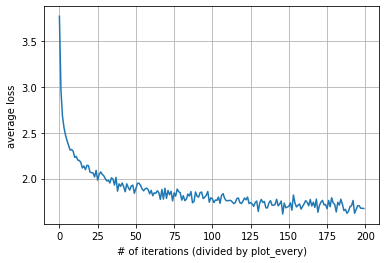

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of iterations (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

### Evaluating at Different Temperatures
Every time we use the `evaluate` function to generate the distribution of the next character, we don't just use softmax as usual, but we also divide by a `temperature`.  
Let's examine the effect of changing the temperature when generating text using our trained model:

In [0]:
print(evaluate('Th', 400, temperature=0.1))

The prince the for the sent the well.

DUKE VINCENTIO:
What the prince the for the for the for the for the for the dear is the for the for the for the for the for the for the for the for the king and the for the for the for the for the dear the for the for the for the for the for the for the for the for the for the for the for the for the for the for the king.

DUKE VINCENTIO:
What with the propples


In [0]:
print(evaluate('Th', 400, temperature=0.5))

Thard let tister a made here right my come,
When you the depose be to fall the conter.

KING RICHARD II:
And death is strike the for me me he may not mard:
For my chath with the report her her I suppire
All then the right her put the hearts man.

ESCALUS:
Where do my the reselves is to deedion,
What the king a warry have be his good grace.

DUKE VINCENTIO:
What is the with the stally be and his with


In [0]:
print(evaluate('Th', 400, temperature=0.8))  # the default value

The did arms:
Is deast face there for Sit in: and is inthey
Give not mistrest one prosster intrust must good.

DUKE VINCENTIO:
Let the is insumped you as I shall is too:
when you shall your despire well for a colds
My Lord that be cant gog's but reasin.
But in the other to kneage is Luncales, fient there deans,
And not may me;
Which the deeds to ectry, and a be of Sit,
Bit a kitagrand, Jone he is th


In [0]:
print(evaluate('Th', 400, temperature=1))

The you sosting York,
I wament to you toos well and seigha.

BUCKINGHAM:
Go, sworg up.

LADY.

HASTINGS:
O you hustime, in he renchar?

DIUS:
What down tone a plashire, semvoy, mesting; thear?
Ought's dructry bother you, fiars, figten--spoth night?

CLARET:
When me have knot I loves murver?

SAPUTIO:
Ghind an I dable and his grives is I
siry! came he is't it than I this pruthine,
Las.

Liedow'd cons


In [0]:
print(evaluate('Th', 400, temperature=1.5))

Than too ooken.
Butunel. In fent imendeop!
!istor this meachipdings a quess,
We chorses an eal I poie? wet yluw's preat,
Toged!

Dell:
His Datact:
Which-caman.
But me himherk was!
O somgy broidind, what: the mideb.,
'hose twest fleg-Our noblve
To the bllood migin broude-
Ga6'od egs the know I nuttay kings?

PLq2OSkURCASS:
Lill; divip hicgarbhestas you lont, wood.

RUCIO:
Rumsms QuUkers.

BESVOLOZEME


### Question 3.c
How does the value of `temperature` affect the properties of the generated text?
Specifically address the process of sampling a character from the next character distribution, and the effect `temperature` has on it.

As the temperature decrease, the generated text includes repeated words. For example, with  `temperature = 0.1` the words "for" and "the" appear many time in the generated text, which are very frequent words in the language.
As the `temperature` increase, but below 1,  the generated text includes  exsiting words, but still without correct sentence structure that has meaningful. When the `temperature` is higher than 1, the generated text includes both non existing words in English and wrong sentence structure. For example, the word "hicgarbhestas" is totally Gibberish.  

In conclusion, We notice that as the `temperature` decreases, the distribution becomes more peaky — probabilities that were larger become even larger, and probabilities that were smaller become even smaller. On the other hand, as you increase `temperature`, the distribution becomes flatter — probabilities that were larger become smaller, and probabilities that were smaller become larger.

